In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output

In [2]:
import os
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import pickle
from collections import defaultdict

from skimage.segmentation import mark_boundaries
from glob import glob
import pandas as pd
import scipy
import cv2
import joblib

from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
import torch
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F

In [4]:
import sys
sys.path.append('../torch_utils/')
sys.path.append('../utils')
sys.path.append('../zoo')
import rles
import dataset as ds
%load_ext autoreload
%autoreload 2
import ternaus_net
%load_ext autoreload
%autoreload 2
import enorm
%load_ext autoreload
%autoreload 2
import augmentations as augs
%load_ext autoreload
%autoreload 2
import learner as lrnr
%load_ext autoreload
%autoreload 2
import torch_funcs as thf
%load_ext autoreload
%autoreload 2
import losses
import metrics
import visualisation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
PATHS = {
    'DATA': '../data/',
    'MASKS': '../data/masks/',
    'ARCHIVE': '../data/indianapolis/',
    'TRAIN': '../data/train',
    'TEST': '../data/test',
    'CSV': '../data/csv',
}

PARAMS = {
    'PATHS': PATHS,
    'SEED': 42,
    'NB_FOLDS': 4,
    'PNG_SIDE': 512,
    'CUDA_DEVICES': [0, 1],
    'INVERSE': 3,
    'BATCH_SIZE': 12,
    'NB_EPOCHS': 10,
    'LR': 2e-4,
    'EXP_GAMMA': .98,
    'CUDA_DEVICES': [0, 1],
}

In [6]:
paths = glob(os.path.join(PATHS['TRAIN'], 'png', '*.png'))

separate = lambda x: os.path.basename(x)
paths = [separate(path) for path in paths]

paths_df = pd.Series([separate(path) for path in paths], name='ImageId')
paths_df = pd.DataFrame(paths_df)
paths = ds.get_paths(paths_df, root_dir=PATHS['TRAIN'])

In [7]:
df = pd.read_csv(os.path.join(PATHS['CSV'], 'stage_1_train_labels.csv'))
df = df.dropna()
df.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [8]:
from skimage.morphology import convex_hull_image


def clip_masks(lmask, mask):
    labeled, colours = scipy.ndimage.label(lmask)
    labeled_pn, colours_pn = scipy.ndimage.label(mask)
    if colours < 2:
        return mask

    colours = np.argsort(np.bincount(labeled[labeled != 0]))[-2:]
    convexs = list()
    centroids = list()

    for colour in colours:
        roi = labeled == colour
        centroids.append(np.median(np.where(roi)[1]))
        convex = convex_hull_image(roi)
        convexs.append(convex)
    labeled *= np.sum(convexs, axis=0)

    for colour_pn in range(1, colours_pn + 1):
        roi_pn = labeled_pn == colour_pn
        comp = roi_pn * labeled
        comp = comp[comp != 0]
        lung = 3
        if len(comp):
            lung = np.argmax(np.bincount(comp))
        mask[roi_pn] = lung

    vec_l = np.array([-1., -1])
    vec_r = np.array([-1., 1])
    vec = [vec_l, vec_r]
    if np.argmax(centroids) == 0:
        vec = vec[::-1]

    for i, convex in enumerate(convexs):    
        dst = scipy.ndimage.distance_transform_edt(np.logical_not(convex))
        gdst = np.array(np.gradient(dst))
        ngdst = np.linalg.norm(gdst, ord=1, axis=0)
        gdst[:, ngdst != 0] /= ngdst[ngdst != 0]

        gdst = gdst * vec[i].reshape((-1, 1, 1))
        roi = mask == colours[i]
        convex |= np.logical_not(np.arcsin(gdst.sum(axis=0)) > -.7)
        mask[roi] = convex[roi] * colours[i]
    mask = scipy.ndimage.binary_fill_holes(mask > 0)

    return mask

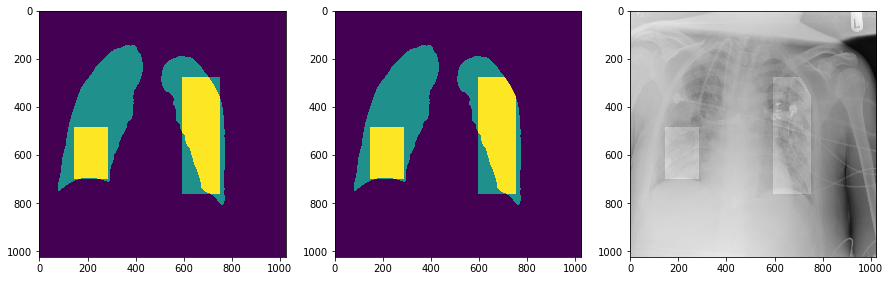

5659it [43:56,  2.15it/s]


In [9]:
for i, key in tqdm(enumerate(df.patientId.unique())):
    pdf = df.query('patientId==@key')
    key += '.dcm.png'

    image = cv2.imread(paths[key]['image'])
    lmask = cv2.imread(paths[key]['mask'], 0)
    lmask = cv2.resize(lmask, image.shape[:-1][::-1])
    mask = np.zeros(image.shape[:-1], dtype=np.uint8)
    for _, row in pdf.iterrows():
        mask[int(row.y): int(row.y) + int(row.height), int(row.x): int(row.x) + int(row.width)] = 255
    
    old_mask = mask.copy()
    mask = clip_masks(lmask > 120, mask)
    cv2.imwrite('../data/train/clipped/' + key, mask.astype(np.uint8) * 255)

    if i % 50 == 0:
        clear_output(wait=True)
        fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
        ax[0].imshow((old_mask > 0) * 1. + (lmask > 120) * 1.)
        ax[1].imshow(mask * 1. + (lmask > 120) * 1.)
        ax[2].imshow(cv2.imread('../data/train/png/' + key) + mask.reshape(mask.shape + (1, )) * 30)
        plt.show()


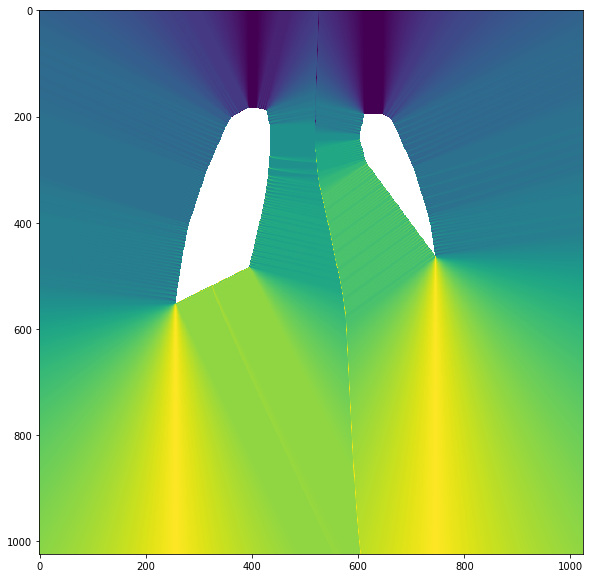

In [106]:

plt.figure(figsize=(10, 10))
plt.imshow(gdst[0])